<a href="https://colab.research.google.com/github/AnujKrishnaPhuyal/DeepLearning-Practices/blob/main/custom_image_for_detection_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import requests
import zipfile
from pathlib import Path
import torch
import torchvision
     

In [6]:
torch.cuda.is_available()

True

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [8]:
torch.__version__

'2.0.1+cu118'

In [9]:

data_path = Path("data/")
image_path = data_path / "hybrid"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    !cp -r "/content/drive/My Drive/hybrid" "/content/data/"

Did not find data/hybrid directory, creating one...


In [10]:
image_path

PosixPath('data/hybrid')

In [11]:
train_dir =image_path/"train"
test_dir = image_path/"test"

In [12]:
train_dir,test_dir

(PosixPath('data/hybrid/train'), PosixPath('data/hybrid/test'))

In [13]:
import os
from PIL import Image
from torchvision.transforms import ToTensor
from PIL import Image
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

In [14]:
from torchvision.utils import ImageColor
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_names = sorted([file for file in os.listdir(folder_path) if file.endswith('.jpg')])
        # Preprocess the image if necessary (e.g., resize, normalize, etc.)

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = os.path.join(self.folder_path, file_name)
        annotation_path = os.path.join(self.folder_path, file_name.replace('.jpg', '.xml'))

        # Load image
        image = Image.open(image_path).convert("RGB")

        transform =transforms.Compose([
            transforms.ToTensor()  # Convert the image to a PyTorch tensor
        ])
        imageee = transform(image)
        # print(imageee.shape)

        transforme = transforms.Compose([
            transforms.Resize((524, 524)),  # Resize the image to a specific size
            transforms.ToTensor()  # Convert the image to a PyTorch tensor
        ])

        imagee = transforme(image)
        # print(imagee.shape)
        # Load and process the annotation
        annotation = self.load_annotation(annotation_path, imagee, imageee)

        # Convert annotation to the required format for Faster R-CNN
        boxes = torch.tensor(annotation["boxes"], dtype=torch.float32)
        labels = torch.tensor(annotation["labels"], dtype=torch.int64)

        # Return the preprocessed image and annotations
        return imagee, {
            "boxes": boxes,
            "labels": labels
        }

    def __len__(self):
        return len(self.file_names)

    def load_annotation(self, annotation_path, imagee, imageee):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        label_to_idx = {"achyut": 0, "anuj": 1}  # Modify according to your class labels

        image_width, image_height = imagee.shape[2], imagee.shape[1] 
        org_image_width, org_image_height = imageee.shape[2], imageee.shape[1] 


         # Get the width and height of the transformed image

        for obj in root.findall('object'):
            # Extract the bounding box coordinates
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            # Calculate the scaling factor for resizing
            x_scale = image_width/org_image_width
            y_scale =image_height/org_image_height

            # Resize the bounding box coordinates
            xmin_resized = xmin * x_scale
            ymin_resized = ymin * y_scale
            xmax_resized = xmax * x_scale
            ymax_resized = ymax * y_scale

            boxes.append([xmin_resized, ymin_resized, xmax_resized, ymax_resized])

            # Extract the class label
            label = obj.find('name').text
            if label in label_to_idx:
                labels.append(label_to_idx[label])
            else:
                # Handle the case where the label is not present in label_to_idx
                labels.append(-1)  # You can assign a specific value to represent an unknown label

        return {"boxes": boxes, "labels": labels}


In [15]:
train_dataset = CustomDataset(train_dir)
test_dataset = CustomDataset(test_dir)

In [36]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True,num_workers=1)

In [17]:
len(train_data_loader)

7

In [18]:
len(test_data_loader)

17

In [19]:

import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ACHYUT


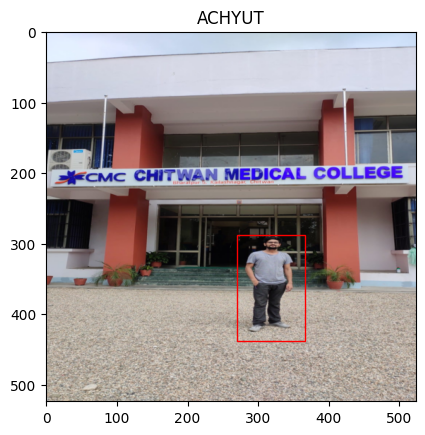

In [20]:

batch = next(iter(test_data_loader))
# for image ,annotations in batch:
image = batch[0]
annotations = batch[1]
boxes_tensor =annotations["boxes"] 
labels = annotations['labels']
# print(annotations['labels'],annotations['boxes'])
if labels == torch.tensor([0]):
  print("ACHYUT")
else:
  print("ANUJ")  
for box in boxes_tensor:

    # Extract the coordinates of the bounding box
    xmin, ymin, xmax, ymax = boxes_tensor[0, 0].tolist()

    # Create a Rectangle patch
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='red')

    # Add the patch to the current axis
    plt.gca().add_patch(rect)

# Display the image with bounding boxes
if labels == torch.tensor([[0]]):
  name = "ACHYUT"
else:
  name="ANUJ"  
plt.title(name)
plt.imshow(image.squeeze(dim=0).permute(1,2,0))




In [21]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [22]:
model_0 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 272MB/s]


In [23]:
model_0

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [40]:
num_classes = 2
in_features = model_0.roi_heads.box_predictor.cls_score.in_features
model_0.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


In [25]:
model_0

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [41]:
params = [p for p in model_0.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# 5. Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_0.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [28]:
from tqdm.auto import tqdm


In [57]:
from torch import nn
loss_fn = nn.CrossEntropyLoss()

In [29]:
num_epochs = 2

In [45]:
for epoch in tqdm(range(num_epochs)):
  model_0.train()
  for (images, targets) in train_data_loader:
    # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    images = list(image.to(device) for image in images)

    # Extract boxes and labels
    boxes = targets['boxes'].cuda()
    labels = targets['labels'].cuda()
     # Convert the targets into the expected format
    targets = []
    total_loss=0
    for i in range(len(images)):
        target = {}
        target['boxes'] = boxes[i]
        target['labels'] = labels[i]
        targets.append(target)

    train_loss_dict = model_0(images, targets)
    # print(train_loss_dict)



    #if u want to observe the individual losses first print to check the loss dicts
    # print(train_loss_dict.keys())
    # loss_classifier = train_loss_dict['loss_classifier']
    # loss_box_reg = train_loss_dict['loss_box_reg']
    # loss_rpn_box_reg = train_loss_dict['loss_rpn_box_reg']
    # loss_objectness = train_loss_dict['loss_objectness']

    # # Convert the losses to scalar values
    # loss_classifier_scalar = loss_classifier.item()
    # loss_box_reg_scalar = loss_box_reg.item()
    # loss_rpn_box_reg_scaler = loss_rpn_box_reg.item()
    # loss_objectness_scaler=loss_objectness.item()

    # total_loss+=loss_box_reg_scalar+loss_classifier_scalar+loss_rpn_box_reg_scaler+loss_objectness_scaler
    # print(f"total_loss{total_loss}loss_classifier_scalar:{loss_classifier_scalar},loss_box_reg_scalar:{loss_box_reg_scalar}")
    sum_keys_losses = sum(loss for loss in train_loss_dict.values())
    total_loss +=sum_keys_losses
    # print(total_loss)
  # print(f"train_loss :{total_loss/len(train_data_loader)} for epoch{epoch}")

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  # lr_scheduler.step()
  print(f"image loss is:{total_loss},in epoch:{epoch}")

# model_0.eval()
  # with torch.inference_mode():
  #   for (images, targets) in test_data_loader:
  #   # targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
  #     images = list(image.to(device) for image in images)

  #     # Extract boxes and labels
  #     boxes = targets['boxes'].cuda()
  #     labels = targets['labels'].cuda()
  #     # Convert the targets into the expected format
  #     targets = []
  #     for i in range(len(images)):
  #         target = {}
  #         target['boxes'] = boxes[i]
  #         target['labels'] = labels[i]
  #         targets.append(target)

  #     test_loss_dict = model_0(images, targets)
  #     test_losses = sum(loss for loss in test_loss_dict.values())

  #     # print(test_loss_dict)
  #     # test_losses = sum(loss for loss in test_loss_dict.values())
  # print(f"Epoch {epoch+1}/{num_epochs}, train:Loss: {train_losses},test_loss:{test_losses} ")  




  0%|          | 0/2 [00:00<?, ?it/s]

image loss is:0.014056341722607613,in epoch:0
image loss is:0.007937773130834103,in epoch:1


In [71]:
import torch.nn.functional as F
model_0.eval()
# with torch.inference_mode():
tot_loss=0
for images,targets in test_data_loader:
  with torch.no_grad():
    images = list(image.to(device) for image in images)
    # Extract boxes and labels
    boxes = targets['boxes'].cuda()
    labels = targets['labels'].cuda()
    # Convert the targets into the expected format
    targets = []
    for i in range(len(images)):
        target = {}
        target['boxes'] = boxes[i]
        # print( target['boxes'] )
        target['labels'] = labels[i]
        # print(target['labels'])
        targets.append(target)
  # print(images)
    test_loss_dict = model_0(images,targets)
    # print(test_loss_dict)
    for i in range(len(test_loss_dict)):
  # Extract the predicted bounding boxes, labels, and scores
      pred_boxes = test_loss_dict[i]['boxes']
      pred_labels = test_loss_dict[i]['labels']
      pred_scores = test_loss_dict[i]['scores']
 # Convert the labels and scores to floating-point type
      pred_labels = pred_labels.float()
      pred_scores = pred_scores.float()

      # Apply softmax to the scores
      print(pred_scores)
  
   
    



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


tensor([0.0833], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.1460, 0.0698], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.1598], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.1146], device='cuda:0')
tensor([0.0936], device='cuda:0')
tensor([0.0931], device='cuda:0')
tensor([], device='cuda:0')
tensor([0.1896], device='cuda:0')
